In [1691]:
import numpy as np
from matplotlib import pyplot as plt

In [1692]:
!curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz
!tar -x -z -f /tmp/data.tar.gz
!rm -f /tmp/data.tar.gz

In [1693]:
trainxs = np.load("comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = np.load("comp0090_assignment_1_data/fashion-test-imgs.npz").transpose((2, 1, 0))
testys  = np.load("comp0090_assignment_1_data/fashion-test-labels.npz")

In [1694]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)
print(testxs.shape)
print(testys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)
(1000, 28, 28)
(1000,)


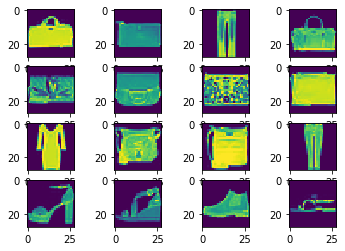

In [1695]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))])

## 3.1 Analytical Gradients

Derived them on ipad, i'd rather confirm the results with someone before typing it all out cause it's painful.

## 3.2 Verifying Gradients Correctness

Queue Adam's code here

## 3.3 Implementing the algorithm

In [1696]:
# sigmoid for a single sample, preventing overflow
def sigmoid(z):
#     return 1. / (1. + np.exp(-z))
    return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

In [1697]:
# sigmoid derivative
def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [1698]:
# forward pass
def forward(params, x):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    
    return forward_res

In [1699]:
# idk what those are and at this point i'm too scared to ask
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [1700]:
# backpropagation
def backprop(x, y, params, forward_res):
    x = x.reshape(28**2, 1)
    
    grads = {}
    
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["W2"].dot(a1) + params["b2"]
    a2 = sigmoid(z2)
    
    z3 = params["W3"].dot(a2) + params["b3"]
    y_pred = a3 = sigmoid(z3)
    
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_d(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(params["W3"]).T * sigmoid_d(z2) # (20, 1)
    dL_dz1 = np.multiply(dL_dz2.T.dot(params["W2"]).T, sigmoid_d(z1)) # (200, 1)
    
    grads["dW3"] = dL_dz3.dot(a2.T) # (1, 20) <- not sure those are right didn't check
    grads["db3"] = dL_dz3 # (1, 1)
    
    grads["dW2"] = dL_dz2.dot(a1.T) # (20, 200)
    grads["db2"] = dL_dz2 # (20, 1)
    
    grads["dW1"] = dL_dz1.dot(x.T) # (784, 200)
    grads["db1"] = dL_dz1 # (200, 1)

    return grads

In [1701]:
def update_params(grads, params, lr, momentum):
#     I DO NOT KNOW WHAT THIS IS
# THIS IS WITH MOMENTUM BUT I DONT THINK WE NEED IT UWU
    # with momentum (optional)
#     if epoch == 0:
#                dW1 = 0
#                db1 = 0
#                ...
#     dW1 = momentum * dW1 + (1 - momentum) * grads["dW1"]
#     db1 = momentum * db1 + (1 - momentum) * grads["db1"]
#     dW2 = momentum * dW2 + (1 - momentum) * grads["dW2"]
#     db2 = momentum * db2 + (1 - momentum) * grads["db2"]
#     dW3 = momentum * dW3 + (1 - momentum) * grads["dW3"]
#     db3 = momentum * db3 + (1 - momentum) * grads["db3"]

    params["W1"] += (lr * grads["dW1"])
    params["b1"] += lr * grads["db1"]
    params["W2"] += (lr * grads["dW2"])
    params["b2"] += lr * grads["db2"]
    params["W3"] += (lr * grads["dW3"])
    params["b3"] += lr * grads["db3"]
    return params

In [1702]:
def update_grads(grads, ups):
    grads["dW3"] -= ups["dW3"] 
    grads["db3"] -= ups["db3"]
    
    grads["dW2"] -= ups["dW2"] 
    grads["db2"] -= ups["db3"] 
    
    grads["dW1"] -= ups["dW1"] 
    grads["db1"] -= ups["db1"] 
    return grads

In [1714]:
def mlp(xs, ys, learning_rate, momentum):
    img_size = 28**2
    h1 = 200
    h2 = 20
    out_size = 1
    
    #     stores training set loss for part 3.5
    loss_training = []
    
    #     stores training set accuracy for part 3.6
    accuracy_training = []
    
    #     stores validation set accuracy for part 3.7
    accuracy_validation = []
    
    # initialise parameters
    params = {"W1": np.random.randn(h1, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h1, 1)),
              "W2": np.random.randn(h2, h1) * np.sqrt(1 / h1),
              "b2": np.zeros((h2, 1)),
              "W3": np.random.randn(out_size, h2) * np.sqrt(1 / h2),
              "b3": np.zeros((out_size, 1))}
    
    grads = {}
    
    loss_old = validation_loss(devxs, devys, params)
    print('loss_old', loss_old)
    
    epoch = 0
    row_epoch = 0
        
    while True:
        # shuffle training set
        permutation = np.random.permutation(trainxs.shape[0])
        trainxs_shuffled = trainxs[p]
        trainys_shuffled = trainys[p]
        grads["dW3"] = np.zeros_like(params["W3"])
        grads["db3"] = np.zeros_like(params["b3"])

        grads["dW2"] = np.zeros_like(params["W2"])
        grads["db2"] = np.zeros_like(params["b2"])

        grads["dW1"] = np.zeros_like(params["W1"])
        grads["db1"] = np.zeros_like(params["b1"])
        
        print("epoch", epoch)
        for i in range (trainxs.shape[0]):
            forward_res = forward(params, trainxs_shuffled[i])
            ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
            grads = update_grads(grads, ups)
        
        grads["dW3"] /= trainxs.shape[0]
        grads["db3"] /= trainxs.shape[0]

        grads["dW2"] /= trainxs.shape[0]
        grads["db2"] /= trainxs.shape[0]

        grads["dW1"] /= trainxs.shape[0]
        grads["db1"] /= trainxs.shape[0]

        params = update_params(grads, params, learning_rate, momentum)
        loss_t = validation_loss(trainxs, trainys, params)
        loss_training.append(loss_t)
        
        accuracy_t = accuracy(trainxs, trainys, params)
        accuracy_training.append(accuracy_t)
    
        accuracy_valid = accuracy(devxs, devys, params)
        accuracy_validation.append(accuracy_valid)
        
        loss_valid = validation_loss(devxs, devys, params)
        print('validation loss', loss_valid)
        print('training accuracy', accuracy_t)
        if np.abs(loss_valid - loss_old) < 0.001:
            row_epoch += 1
            if row_epoch == 3:
                break
        else:
            row_epoch = 0
        loss_old = loss_valid
        epoch += 1
    return epoch, loss_training, accuracy_training, accuracy_validation

In [1715]:
def predict_mlp(x, params):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["W2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    forward_res["z3"] = params["W3"] @ forward_res["a2"] + params["b3"]
    forward_res["a3"] = sigmoid(forward_res["z3"])
    if forward_res["a3"] >= 0.5:
        return 1
    return 0

In [1716]:
# function to calculate accuracy
def accuracy(devxs, devys, params):
    accuracy = 0
    for i in range (devxs.shape[0]):
        yp = predict_mlp(devxs[i], params)
        if (yp == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

In [1717]:
# function to determine loss
def validation_loss(devxs, devys, params):
    loss = 0
    for i in range (devxs.shape[0]):
        yprime = predict_mlp(devxs[i], params)
        py = sigmoid(yprime)
        if (py == 0 and devys[i] == 1 or py == 1 and devys[i] == 0):
            py += 1e-15
        elif devys[i] == 1:
            loss += np.log(py)
        else:
            loss += np.log(1 - py)
    return ((-1) / devys.shape[0]) * loss

## 3.4 Training model to convergence

Convergence is defined as no improvement in validation loss over 3 consecutive parameter updates.

In [1724]:
# define hyperparameters

# full-batch gradient descent, so not using batch_size as a parameter
learning_rate = 0.4
momentum = 0.9

In [1725]:
epoch, loss_training, accuracy_training, accuracy_validation = mlp(trainxs, trainys, learning_rate, momentum)

loss_old 0.8082616875182138
epoch 0
validation loss 0.796898481323382
training accuracy 51.40833333333333
epoch 1
validation loss 0.7066577555639337
training accuracy 64.14999999999999
epoch 2
validation loss 0.6663112286673126
training accuracy 71.34166666666667
epoch 3
validation loss 0.6390261903611489
training accuracy 75.56666666666668
epoch 4
validation loss 0.625422755152401
training accuracy 77.65833333333333
epoch 5
validation loss 0.6128193199436534
training accuracy 79.05833333333334
epoch 6
validation loss 0.6055176023392796
training accuracy 80.19166666666668
epoch 7
validation loss 0.6012158847349055
training accuracy 81.0
epoch 8
validation loss 0.5975342816374897
training accuracy 81.45833333333333
epoch 9
validation loss 0.5922325640331156
training accuracy 81.80833333333334
epoch 10
validation loss 0.5892716479774494
training accuracy 82.0
epoch 11
validation loss 0.5881710754426581
training accuracy 82.30833333333332
epoch 12
validation loss 0.588690617414825
trainin

## 3.5 Loss plot for training set

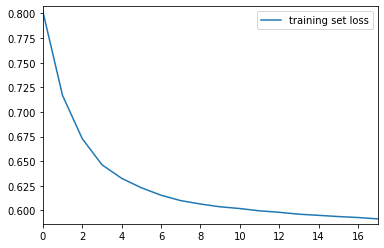

In [1726]:
plt.axis([0, epoch, min(loss_training) - 0.005, max(loss_training) + 0.005])
plt.plot(loss_training, label='training set loss')
plt.legend(loc='upper right')

## 3.6 Accuracy plot for training set

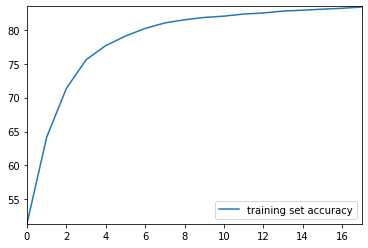

In [1727]:
plt.axis([0, epoch, min(accuracy_training), max(accuracy_training) + 0.1])
plt.plot(accuracy_training, label='training set accuracy')
plt.legend(loc='lower right')

## 3.7 Accuracy for best epoch

In [1728]:
ind = accuracy_validation.index(max(accuracy_validation))

In [1729]:
print("Best epoch =", ind)
print("Accuracy on training set =", accuracy_training[ind])
print("Accuracy on validation set =", accuracy_validation[ind])

Best epoch = 15
Accuracy on training set = 83.025
Accuracy on validation set = 84.1
